<a href="https://colab.research.google.com/github/kchuri01/DistilBERT-Sentiment-Analysis/blob/main/DistilBERT_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q transformers datasets accelerate

import json
import random
import os

import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from torch.utils.data import Dataset
from transformers import (DistilBertTokenizerFast, DistilBertForSequenceClassification,
                          TrainingArguments, Trainer)

import matplotlib.pyplot as plt

**Load the dataset**

In [ ]:
json_path = "/content/all_reviews.json"

In [ ]:
# Flatten the dataset
with open(json_path, "r", encoding="utf-8") as f:
    raw = json.load(f)

# raw is a list of lists; each element is a list of review dicts
rows = []
for block in raw:
    for review in block:
        rows.append(review)

df = pd.DataFrame(rows)
print(df.head())
print(df.columns)
print("Rows:", len(df))

        course_id Quality Difficulty For Credit Would Take Again Grade  \
0          FHS010     5.0        2.0        Yes              Yes     A   
1          FHS010     3.0        1.0        Yes               No   NaN   
2   POLPHILOSOPHY     4.0        1.0        Yes              NaN   NaN   
3          FHS010     5.0        2.0        NaN              NaN   NaN   
4           FHS10     5.0        1.0        NaN              NaN   NaN   

  Textbook                                            Comment       professor  \
0       No  Professor Nichols is super nice and very whole...  James Nichols    
1       No  Very chill class and teacher, very easy grader...  James Nichols    
2      Yes  Awesome, easy, knows literally everything abou...  James Nichols    
3      Yes  Prof. Nichols is a super nice and encouraging ...  James Nichols    
4      Yes  Good Professor. Really nice and encouraging te...  James Nichols    

              department Attendance Online Class  
0  Government dep

**Clean the dataset**

In [ ]:
# Keep only rows with both Comment and Quality
df = df.dropna(subset=["Comment", "Quality"]).copy()

# Remove comments like "No Comments" / "No Comment"
df["Comment"] = df["Comment"].astype(str)
mask_no_comment = df["Comment"].str.strip().str.lower().isin(["no comments", "no comment"])
df = df[~mask_no_comment].copy()

df["Quality"] = df["Quality"].astype(float)

**Create sentiment labels**

In [ ]:
def quality_to_sentiment(q):
    if q <= 2.0:
        return "negative"
    elif q >= 4.0:
        return "positive"
    else:
        return "neutral"

df["sentiment"] = df["Quality"].apply(quality_to_sentiment)
print(df["sentiment"].value_counts())

sentiment
positive    2242
negative     554
neutral      512
Name: count, dtype: int64


**Map sentiments to numeric labels**

In [ ]:
label_names = ["negative", "neutral", "positive"]
label2id = {lab: i for i, lab in enumerate(label_names)}
id2label = {i: lab for lab, i in label2id.items()}

In [ ]:
df["label"] = df["sentiment"].map(label2id)

In [ ]:
df_model = df[["Comment", "Quality", "sentiment", "label"]].rename(columns={"Comment": "text"})
df_model.head()

,text,Quality,sentiment,label
0,Professor Nichols is super nice and very whole...,5.0,positive,2
1,"Very chill class and teacher, very easy grader...",3.0,neutral,1
2,"Awesome, easy, knows literally everything abou...",4.0,positive,2
3,Prof. Nichols is a super nice and encouraging ...,5.0,positive,2
4,Good Professor. Really nice and encouraging te...,5.0,positive,2


**Train/Test split**

In [ ]:
train_df, test_df = train_test_split(df_model, test_size=0.2,
                                     random_state=42,
                                      stratify=df_model["label"])

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train size:", len(train_df), " Test size:", len(test_df))

Train size: 2646  Test size: 662


**Set random seeds**

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

**Tokenizer and custom dataset**

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
class ReviewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(text, truncation=True,
                             padding="max_length",
                             max_length=self.max_length,
                             return_tensors="pt")

        # squeeze batch dimension (from (1, seq_len) to (seq_len,))
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

In [ ]:
train_dataset = ReviewsDataset(train_df["text"], train_df["label"], tokenizer)
test_dataset  = ReviewsDataset(test_df["text"],  test_df["label"],  tokenizer)

len(train_dataset), len(test_dataset)

(2646, 662)

**DistilBERT Model + Trainer**

In [ ]:
num_labels = len(label_names)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels,
                                                            id2label=id2label, label2id=label2id)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
os.environ["WANDB_DISABLED"] = "true"       # disable wandb in Colab

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1  = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": f1}

training_args = TrainingArguments(
    output_dir="distilbert_prof_reviews",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


**Train & Evaluate**

In [ ]:
train_output = trainer.train()
print(train_output)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
50,0.903800
100,0.616600
150,0.587400
200,0.498100
250,0.582200
300,0.492700
350,0.480100
400,0.408300
450,0.359000
500,0.379700


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=993, training_loss=0.437861022872387, metrics={'train_runtime': 11692.0495, 'train_samples_per_second': 0.679, 'train_steps_per_second': 0.085, 'total_flos': 525772481504256.0, 'train_loss': 0.437861022872387, 'epoch': 3.0})


In [ ]:
eval_results = trainer.evaluate()
eval_results

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.5466305017471313,
 'eval_accuracy': 0.7990936555891238,
 'eval_macro_f1': 0.668103648690189,
 'eval_runtime': 282.4792,
 'eval_samples_per_second': 2.344,
 'eval_steps_per_second': 0.294,
 'epoch': 3.0}

**Confusion Matrix on test set**

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


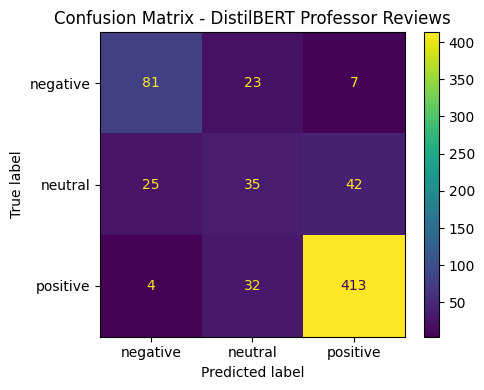

In [ ]:
pred_output = trainer.predict(test_dataset)
y_true = test_df["label"].to_numpy()
y_pred = np.argmax(pred_output.predictions, axis=-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, values_format="d")
plt.title("Confusion Matrix - DistilBERT Professor Reviews")
plt.tight_layout()
plt.show()

**predict_sentiment**

In [ ]:
def predict_sentiment(texts):
    if isinstance(texts, str):
        texts = [texts]

    enc = tokenizer(texts, padding=True,
                    truncation=True,
                    max_length=256,
                    return_tensors="pt")

    model.eval()
    with torch.no_grad():
        outputs = model(**enc)
        probs = F.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).tolist()

    results = []
    for text, p_id, p_vec in zip(texts, preds, probs):
        label = id2label[p_id]
        conf = float(p_vec[p_id])
        results.append({"text": text, "predicted_label": label, "confidence": conf})
    return results

**Example predictions**

In [ ]:
examples = ["Really passionate professor and clearly knows the material. Lectures can go long but you actually learn a lot. Easy grader if you show effort.",
            "Not the most exciting lecturer, but exams are straightforward if you study and pay attention.",
            "Lots of rambling and little structure. Ended up teaching myself most of the material.",
            "Knows the material really well, but talks most of the class and doesn’t encourage much discussion.",
            "Hard class, but totally worth it. He expects a lot, but you walk away understanding the subject way better.",
            "Nice person and pretty chill class, but lectures can be boring and feel unstructured at times.",
            "Nice enough person, but teaching style makes the class very hard to follow. I struggled a lot. I wouldn't recommend.",
            "Avoid if possible. Way more work than expected and grading felt unfair most of the time."]

for r in predict_sentiment(examples):
    print("TEXT:", r["text"])
    print("PRED:", r["predicted_label"], f"(conf={r['confidence']:.3f})")
    print("-" * 60)

TEXT: Really passionate professor and clearly knows the material. Lectures can go long but you actually learn a lot. Easy grader if you show effort.
PRED: positive (conf=0.986)
------------------------------------------------------------
TEXT: Not the most exciting lecturer, but exams are straightforward if you study and pay attention.
PRED: neutral (conf=0.849)
------------------------------------------------------------
TEXT: Lots of rambling and little structure. Ended up teaching myself most of the material.
PRED: negative (conf=0.945)
------------------------------------------------------------
TEXT: Knows the material really well, but talks most of the class and doesn’t encourage much discussion.
PRED: negative (conf=0.543)
------------------------------------------------------------
TEXT: Hard class, but totally worth it. He expects a lot, but you walk away understanding the subject way better.
PRED: positive (conf=0.884)
---------------------------------------------------------